In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
import data_utils
import krige_tools
import fields
import variogram as vgm
import cov_model

# Figure 1: daily and monthly climatologies

In [4]:
def climatology_conus(ds, freq):
    return (
        data_utils.regrid(ds, lon_res=5, lat_res=4, lon_lwr=-125, lon_upr=-65, lat_lwr=12, lat_upr=52)
        .dropna(subset=["lon", "lat"])
        .drop(columns=["lon", "lat"])
        .groupby(pd.Grouper(key="time", freq=freq))
        .mean()
        .reset_index()
    )

In [5]:
with xr.open_dataset("../data/exp_pro/OCO2_Lite_XCO2.nc") as ds:
    ds_xco2 = ds["xco2"]
    
with xr.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc") as ds:
    ds_sif = ds["sif"]

In [6]:
daily_xco2 = climatology_conus(ds_xco2, "1D")
daily_sif = climatology_conus(ds_sif, "1D")
df_daily = pd.merge(daily_xco2, daily_sif, on=["time"], how="outer")

monthly_xco2 = climatology_conus(ds_xco2, "1M")
monthly_sif = climatology_conus(ds_sif, "1M")
df_monthly = pd.merge(monthly_xco2, monthly_sif, on=["time"], how="outer")

../src/data_utils.py:134: UserWarning: WARNING: dataset coordinates not within extents; may produce unexpected behavior.
  "WARNING: dataset coordinates not within extents; may produce unexpected behavior."
../src/data_utils.py:134: UserWarning: WARNING: dataset coordinates not within extents; may produce unexpected behavior.
  "WARNING: dataset coordinates not within extents; may produce unexpected behavior."
../src/data_utils.py:134: UserWarning: WARNING: dataset coordinates not within extents; may produce unexpected behavior.
  "WARNING: dataset coordinates not within extents; may produce unexpected behavior."
../src/data_utils.py:134: UserWarning: WARNING: dataset coordinates not within extents; may produce unexpected behavior.
  "WARNING: dataset coordinates not within extents; may produce unexpected behavior."


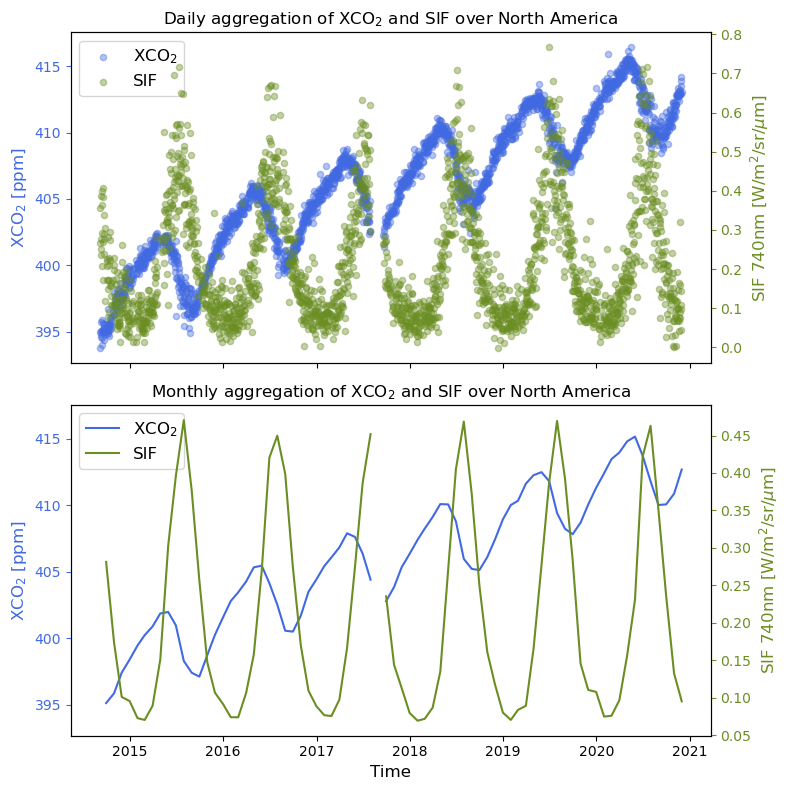

In [7]:
# Plot global daily climatology
# sns.set_style("ticks")
plt.style.use("default")
fig, ax = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)
ax_r1 = ax[0].twinx()
ax_r2 = ax[1].twinx()

# Set variable colors
xco2_color = "royalblue"
sif_color = "olivedrab"

# Line plots
ax_r1.scatter(df_daily["time"], df_daily["sif"], color=sif_color, s=20, alpha=0.4, label="SIF")
ax[0].scatter(df_daily["time"], df_daily["xco2"], color=xco2_color, s=20, alpha=0.4, label="XCO$_2$", zorder=10)
ax[0].scatter([], [], color=sif_color, s=20, alpha=0.4, label="SIF")

# Customize axes
ax[0].tick_params(axis="y", colors=xco2_color, labelsize=10)
ax_r1.tick_params(axis="y", colors=sif_color, labelsize=10)
ax[0].yaxis.label.set_color(xco2_color)
ax_r1.yaxis.label.set_color(sif_color)
ax[0].legend(loc="upper left", fontsize=12)

# Add titles
ax_r1.set_ylabel("SIF 740nm [W/m$^2$/sr/$\mu$m]", size=12)
ax[0].set_ylabel("XCO$_2$ [ppm]", size=12)
ax[0].set_title("Daily aggregation of XCO$_2$ and SIF over North America", size=12)



# Line plots
ax_r2.plot(df_monthly["time"], df_monthly["sif"], color=sif_color, label="SIF")
ax[1].plot(df_monthly["time"], df_monthly["xco2"], color=xco2_color, label="XCO$_2$", zorder=10)
ax[1].plot([], [], color=sif_color, label="SIF")

# Customize axes
ax[1].tick_params(axis="x", labelsize=10)
ax[1].tick_params(axis="y", colors=xco2_color, labelsize=10)
ax_r2.tick_params(axis="y", colors=sif_color, labelsize=10)
ax[1].yaxis.label.set_color(xco2_color)
ax_r2.yaxis.label.set_color(sif_color)
ax[1].legend(loc="upper left", fontsize=12)

# Add titles
ax_r2.set_ylabel("SIF 740nm [W/m$^2$/sr/$\mu$m]", size=12)
ax[1].set_ylabel("XCO$_2$ [ppm]", size=12)
ax[1].set_xlabel("Time", size=12)
ax[1].set_title("Monthly aggregation of XCO$_2$ and SIF over North America", size=12)

plt.tight_layout()
plt.savefig("../plots/climatologies_conus.png", dpi=200);

# Figure 2: gridded datasets

In [4]:
ds = xr.open_dataset("../data/exp_pro/OCO2_4x5deg_monthly_conus.nc")

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]

var_names = ["xco2", "sif"]
cross_name = "xco2:sif"

In [5]:
# Analysis variables
month = 7
timedelta = -1
n_bins = 50
fast_dist = False

timestamp = np.array(ds.time[ds.time.dt.month == month].values, dtype="datetime64[D]")[2]

In [6]:
timestamp

numpy.datetime64('2017-07-01')

In [7]:
mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, fast_dist=fast_dist)

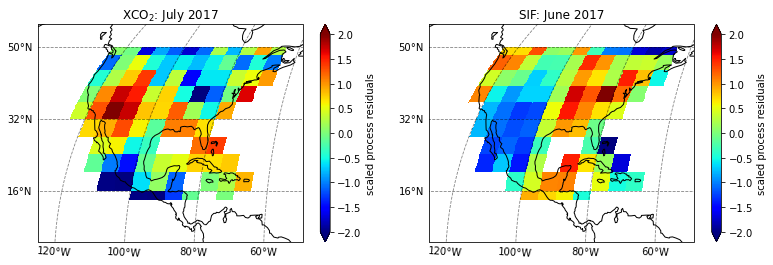

In [39]:
# Plot maps
da_xco2 = mf.field_1.ds.xco2
da_sif = mf.field_2.ds.sif

fig = plt.figure(figsize=(14, 4))
gs = fig.add_gridspec(100, 100)
extents = [-125, -60, 5, 52]

ax1 = fig.add_subplot(gs[:, 0:45], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:, 50:95], projection=ccrs.EqualEarth())

xr.plot.imshow(
        darray=da_xco2.T,
        transform=ccrs.PlateCarree(),
        ax=ax1,
        cmap="jet",
        vmin=-2,
        center=0,
        cbar_kwargs={"label": "scaled process residuals"},
    )
ax1.coastlines()
ax1.set_extent(extents)
ax1.set_title("XCO$_2$: July 2017", fontsize=12)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.8, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl1.top_labels = False
gl1.left_labels = True
gl1.right_labels = False
gl1.xlines = True
gl1.ylines = True
gl1.xlocator = mticker.FixedLocator([-120, -100, -80, -60])
gl1.ylocator = mticker.FixedLocator([16, 32, 50])
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER

xr.plot.imshow(
        darray=da_sif.T,
        transform=ccrs.PlateCarree(),
        ax=ax2,
        cmap="jet",
        vmin=-2,
        center=0,
        cbar_kwargs={"label": "scaled process residuals"},
    )
ax2.coastlines()
ax2.set_extent(extents)
ax2.set_title(f"SIF: June 2017", fontsize=12)
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), linewidth=0.8, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl2.top_labels = False
gl2.left_labels = True
gl2.right_labels = False
gl2.xlines = True
gl2.ylines = True
gl2.xlocator = mticker.FixedLocator([-120, -100, -80, -60])
gl2.ylocator = mticker.FixedLocator([16, 32, 50])
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER

fig.savefig(f"../plots/gridded_data.png", dpi=200);

# Figure 3 & 4: fitted semivariograms and covariograms

In [11]:
def param_labels(params, cross=False):
    p = np.round_(params, decimals=3)
    if cross:
        return f"nu: {p[0]}\n len_scale: {p[1]}\n rho: {p[2]}"
    else:
        return f"sigma: {p[0]}\n nu: {p[1]}\n len_scale: {p[2]}\n tau: {p[3]}"
    

def plot_semivariograms(vario_res, timestamp, params, sigmas, nuggets):
    pred = np.linspace(0, 3100, 100)
    fits = [vgm.matern_vario(pred, *params["xco2"]), vgm.matern_vario(pred, *params["sif"])]
    fit_cross = vgm.matern_cross_vario(pred, sigmas, nuggets, *params[cross_name])

    fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
    ax[0, 1].axis("off")
    
    lags = vario_res["xco2"]["bin_center"].values
    bin_width = lags[2] - lags[1]

    for i, var in enumerate(var_names):
        df = vario_res[var]
        ax[i, i].scatter(df["bin_center"], df["bin_mean"],  color="black")
        ax[i, i].plot(pred, fits[i], linestyle="--", color="black")
        ax[i, i].set_title(var, fontsize=12)
        ax[i, i].set_ylabel("semivariance", fontsize=12)
        ax[i, i].text(0.95, 0.05, param_labels(params[var]), transform=ax[i, i].transAxes, ha="right", va="bottom")

    ax[1, 1].set_xlabel("separation distance (km)", fontsize=12)

    df = vario_res[cross_name]
    ax[1, 0].scatter(df["bin_center"], df["bin_mean"],  color="black")
    ax[1, 0].plot(pred, fit_cross, linestyle="--", color="black")
    ax[1, 0].text(0.05, 0.05, param_labels(params[cross_name], cross=True), transform=ax[1, 0].transAxes, ha="left", va="bottom")
    ax[1, 0].set_ylabel("semivariance", fontsize=12)
    ax[1, 0].set_xlabel("separation distance (km)", fontsize=12)

    ax[0, 0].set_title("Semivariogram: XCO$_2$", fontsize=12)
    ax[1, 0].set_title(f"Cross-semivariogram: XCO$_2$ with SIF at {np.abs(timedelta)} month lag", fontsize=14)
    ax[1, 1].set_title("Semivariogram: SIF", fontsize=12)

    fig.suptitle("Semivariograms and cross-semivariogram for XCO$_2$ and SIF residuals over North America\n"+
                f"July 2017, 4x5 degree resolution, bin width {np.int(bin_width)} (km)", fontsize=12)
    plt.tight_layout()
    fig.savefig(f"../plots/semivariograms_conus4x5.png", dpi=200);
    
    
def plot_covariograms(covario_res, timestamp, params, sigmas, nuggets):
    pred = np.linspace(0, 3100, 100)
    fits = [vgm.matern_cov(pred, *params["xco2"]), vgm.matern_cov(pred, *params["sif"])]
    fit_cross = vgm.matern_cross_cov(pred, sigmas, *params[cross_name])
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
    ax[0, 1].axis("off")
    
    lags = covario_res["xco2"]["bin_center"].values
    bin_width = lags[2] - lags[1]

    for i, var in enumerate(var_names):
        df = covario_res[var]
        ax[i, i].scatter(df["bin_center"], df["bin_mean"],  color="black")
        ax[i, i].plot(pred, fits[i], linestyle="--", color="black")
        ax[i, i].set_title(var, fontsize=12)
        ax[i, i].set_ylabel("covariance", fontsize=12)
        ax[i, i].text(0.05, 0.05, param_labels(params[var]), transform=ax[i, i].transAxes, ha="left", va="bottom")
        
    ax[1, 1].set_xlabel("separation distance (km)", fontsize=12)

    df = covario_res[cross_name]
    ax[1, 0].scatter(df["bin_center"], df["bin_mean"],  color="black")
    ax[1, 0].plot(pred, fit_cross, linestyle="--", color="black")
    ax[1, 0].text(0.95, 0.05, param_labels(params[cross_name], cross=True), transform=ax[1, 0].transAxes, ha="right", va="bottom")
    ax[1, 0].set_ylabel("cross covariance", fontsize=12)
    ax[1, 0].set_xlabel("separation distance (km)", fontsize=12)

    ax[0, 0].set_title("Covariogram: XCO$_2$", fontsize=12)
    ax[1, 0].set_title(f"Cross-covariogram: XCO$_2$ with SIF at {np.abs(timedelta)} month lag", fontsize=12)
    ax[1, 1].set_title("Covariogram: SIF", fontsize=12)

    fig.suptitle("Covariograms and cross-covariogram for XCO$_2$ and SIF residuals over North America\n"+
                f"July 2017, 4x5 degree resolution, bin width {np.int(bin_width)} (km)", fontsize=12)
    plt.tight_layout()
    fig.savefig(f"../plots/covariograms_conus4x5.png", dpi=200);

In [8]:
# Set model params manually
params = {
    "xco2": [1.04, 2.71, 889.11, 0.16],
    "sif": [1.09, 3.38, 984.04, 0.10],
    "xco2:sif": [4.15, 820.54, -0.21]
}
sigmas = [params["xco2"][0], params["sif"][0]]
nuggets = [params["xco2"][3], params["sif"][3]]

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


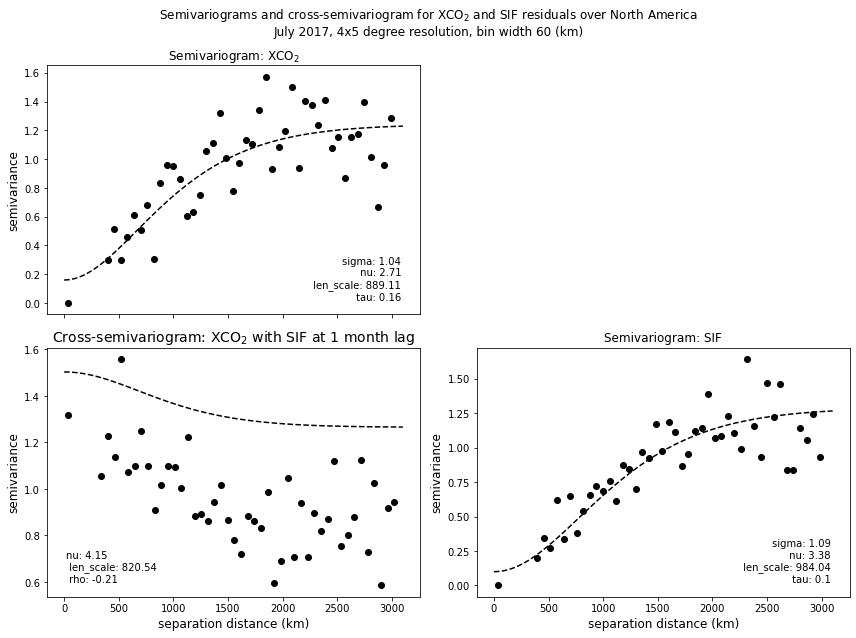

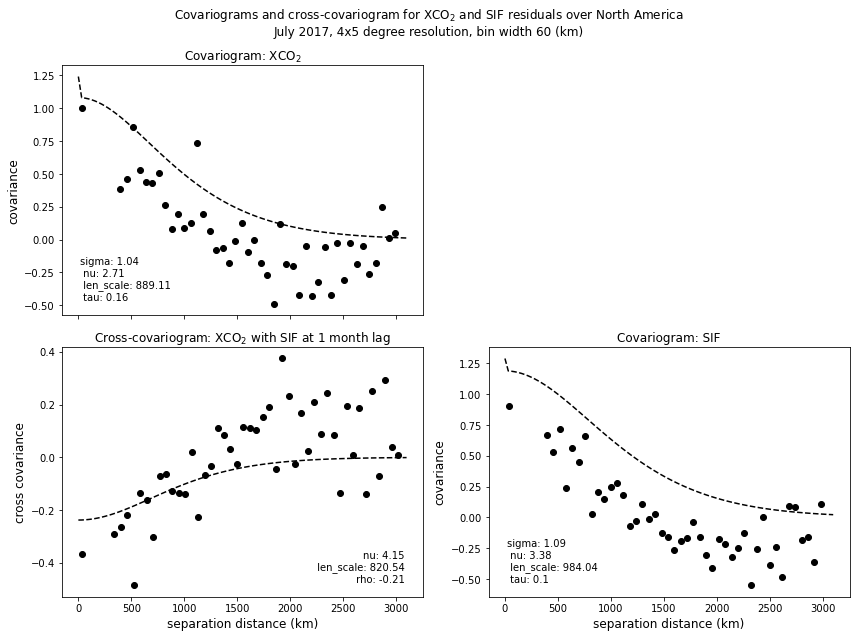

In [12]:
vario_res, covario_res, _ = vgm.variogram_analysis(mf, [], [], n_bins=n_bins)

lags = vario_res["xco2"]["bin_center"].values
bin_width = lags[2] - lags[1]

# Plot variograms
plot_semivariograms(vario_res, timestamp, params, sigmas, nuggets)
plot_covariograms(covario_res, timestamp, params, sigmas, nuggets)

## Additional Figures

In [10]:
def plot_semivariograms_nofit(timestamp):
    mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, fast_dist=fast_dist)
    vario_res, covario_res, _ = vgm.variogram_analysis(mf, [], [], n_bins=n_bins)
    lags = vario_res["xco2"]["bin_center"].values
    bin_width = lags[2] - lags[1]
    
    pred = np.linspace(0, 3100, 100)

    fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
    ax[0, 1].axis("off")
    
    lags = vario_res["xco2"]["bin_center"].values
    bin_width = lags[2] - lags[1]

    for i, var in enumerate(var_names):
        df = vario_res[var]
        ax[i, i].scatter(df["bin_center"], df["bin_mean"],  color="black")
        ax[i, i].set_title(var, fontsize=12)
        ax[i, i].set_ylabel("semivariance", fontsize=12)

    ax[1, 1].set_xlabel("separation distance (km)", fontsize=12)

    df = vario_res[cross_name]
    ax[1, 0].scatter(df["bin_center"], df["bin_mean"],  color="black")
    ax[1, 0].set_ylabel("semivariance", fontsize=12)
    ax[1, 0].set_xlabel("separation distance (km)", fontsize=12)

    ax[0, 0].set_title("Semivariogram: XCO$_2$", fontsize=12)
    ax[1, 0].set_title(f"Cross-semivariogram: XCO$_2$ with SIF at {np.abs(timedelta)} month lag", fontsize=12)
    ax[1, 1].set_title("Semivariogram: SIF", fontsize=12)

    fig.suptitle("Semivariograms and cross-semivariogram for XCO$_2$ and SIF residuals over North America\n"+
                f"{timestamp}, 4x5 degree resolution, bin width {np.int(bin_width)} (km)", fontsize=12)
    fig.savefig(f"../plots/semivariograms_conus4x5_{timestamp}.png", dpi=200);

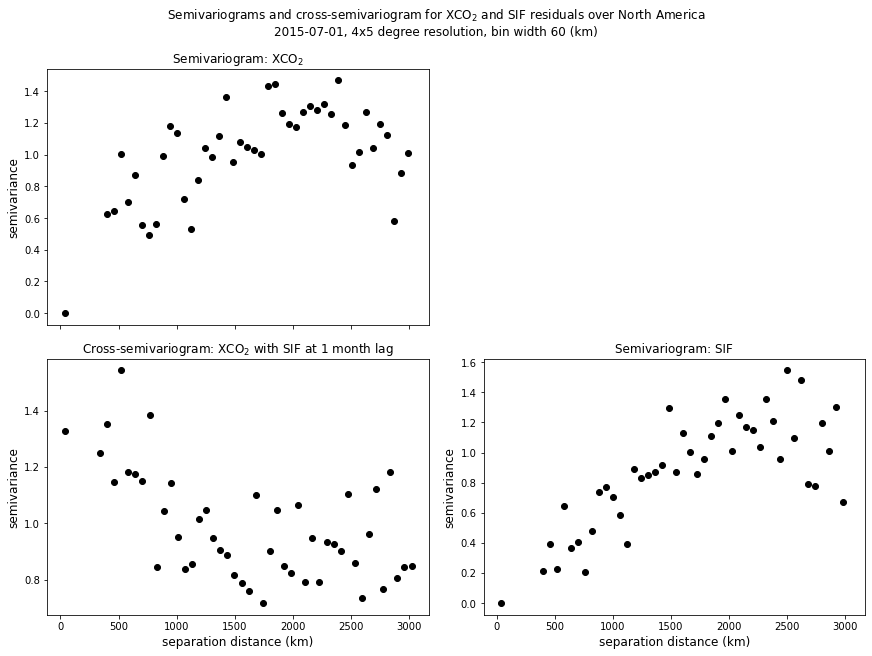

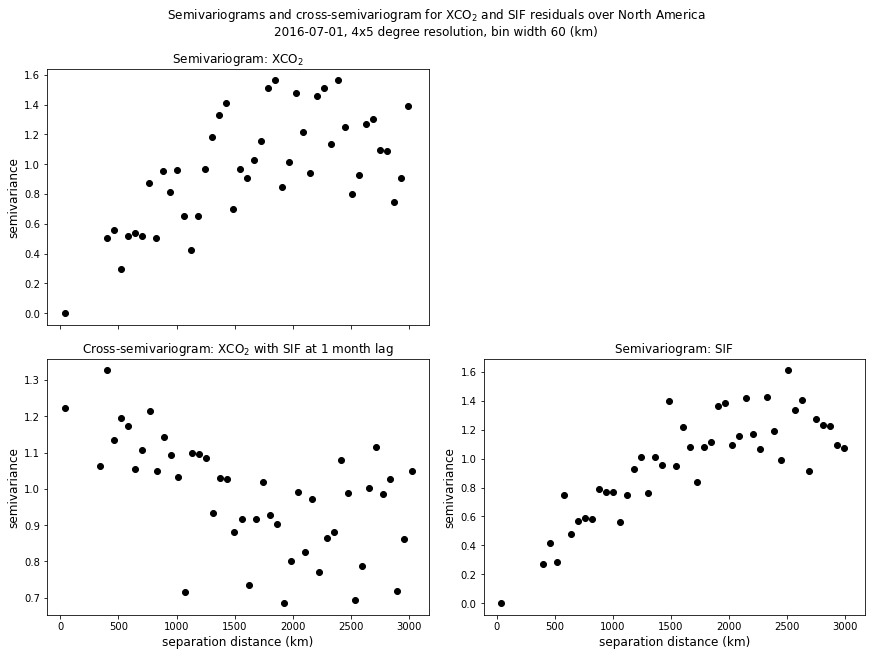

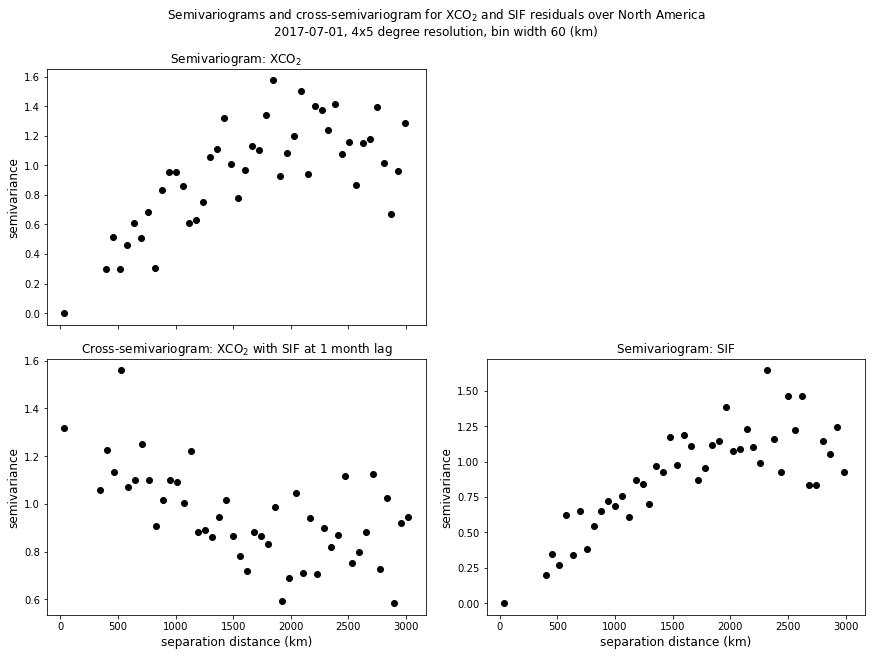

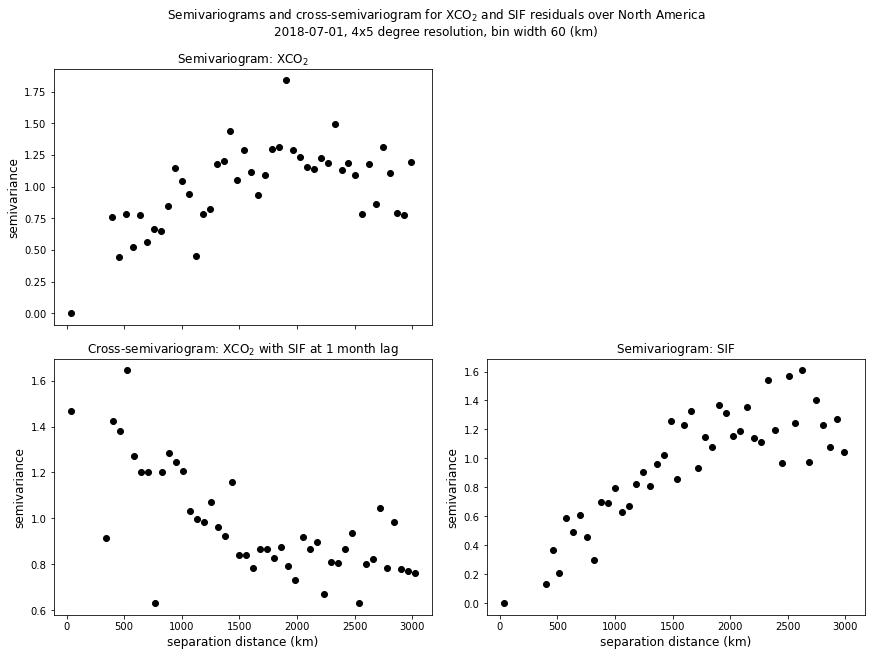

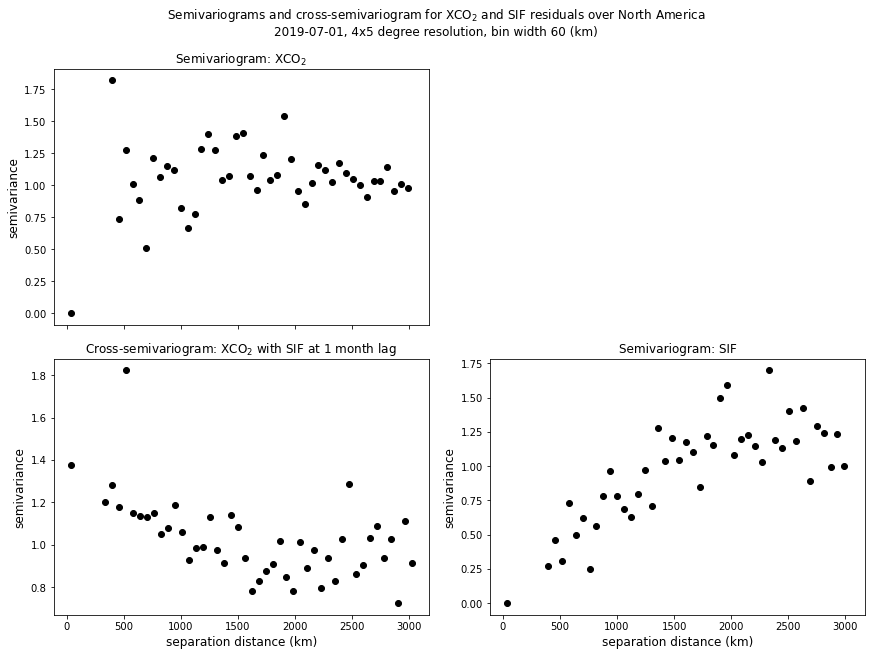

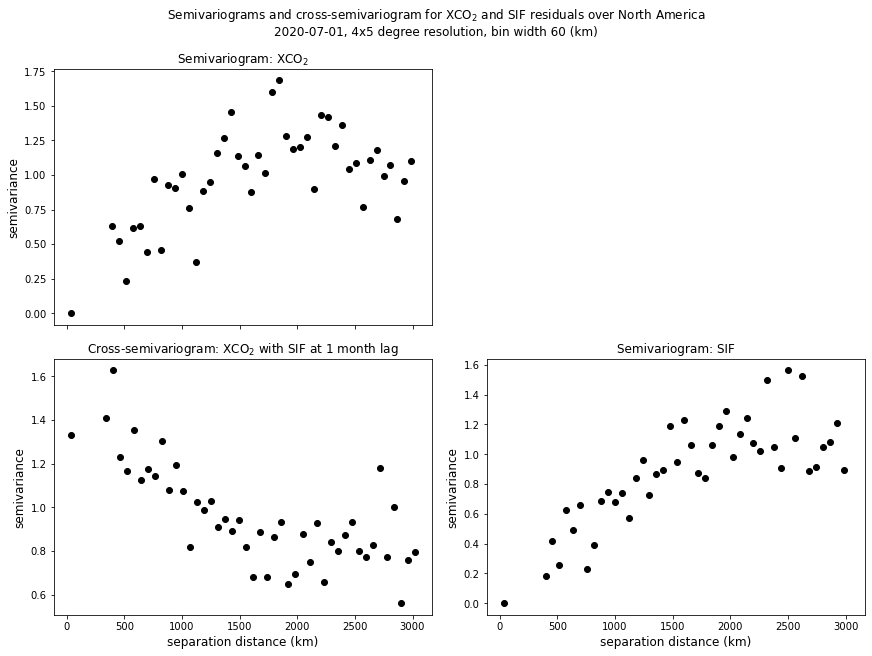

In [11]:
# 1-month lag
month = 7
timedelta = -1
n_bins = 50
fast_dist = False

timestamps = np.array(ds.time[ds.time.dt.month == month].values, dtype="datetime64[D]")
[plot_semivariograms_nofit(timestamp) for timestamp in timestamps];

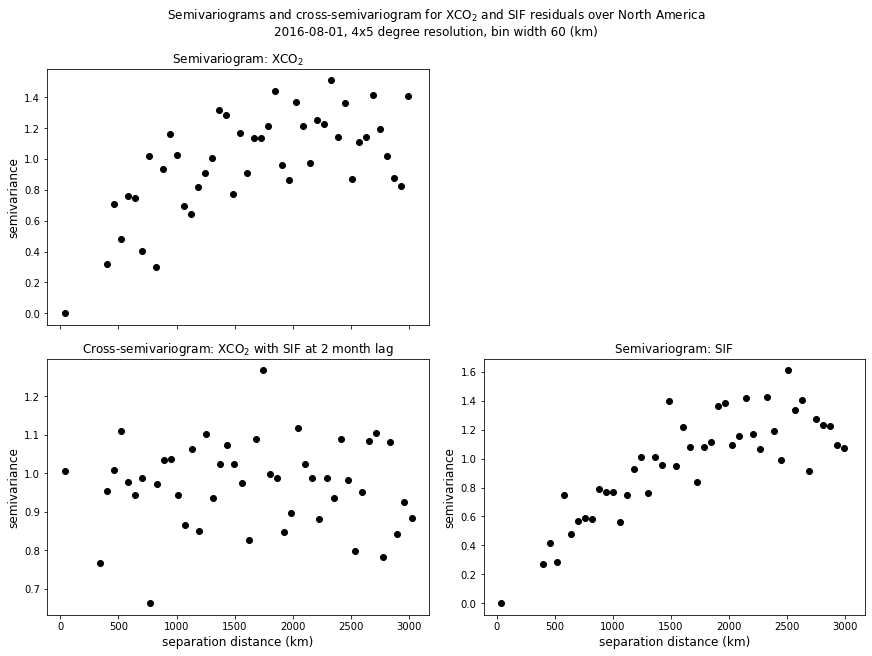

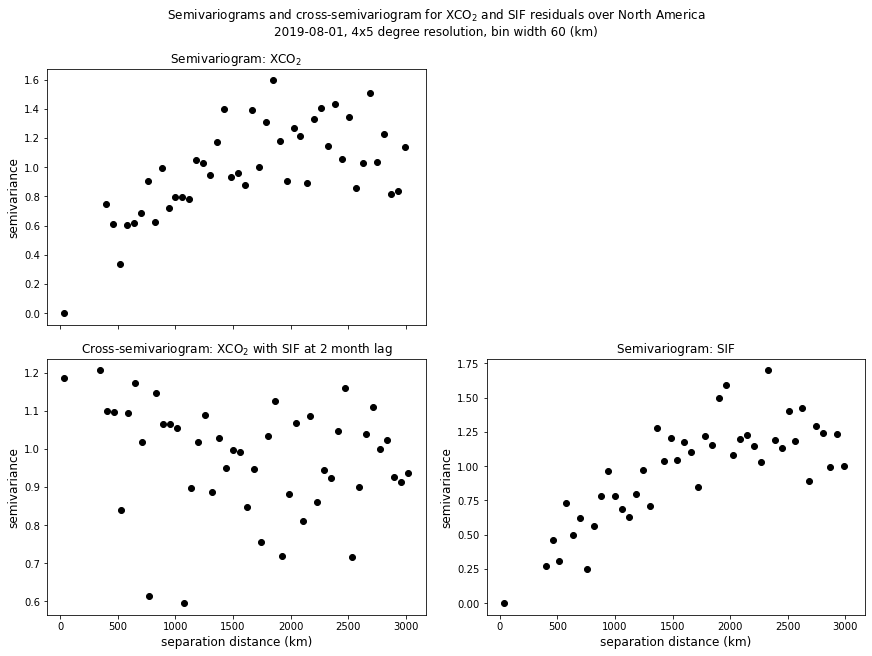

In [15]:
# 2-month lag
month = 8
timedelta = -2
n_bins = 50
fast_dist = False

timestamps = np.array(ds.time[ds.time.dt.month == month].values, dtype="datetime64[D]")
[plot_semivariograms_nofit(timestamp) for timestamp in timestamps[[1, -2]]];